## 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷

### 규제 선형 모델 개요

* **cost func** = Min(RSS(W) + **alpha** * $||W||^2_2$)
* 최적모델을 위한 cost함수의 구성요소 = 학습데이터 잔차 오류 최소화 + 회귀계수 크기 제어
* **alpha**: 0에서부터 지속적으로 증가시키면 회귀 계수 값의 크기를 감소시킬 수 있음
    * alpha가 클수록 회귀계수 W값을 작게 해 과적합을 개선할 수 있음
    * alpha가 작으면 회귀계수 W값이 커져도 어느정도 상쇄 가능
    * 이 방식을 Regularization이라고 부름

## 릿지 회귀

* W의 제곱(L2 Regularization)에 대해 페널티를 부여하는 방식

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

# boston 데이터 세트 로드
boston = load_boston()

# boston 데이터 세트 DataFrame 변환
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

# boston 데이터 세트의 target 배열은 주택 가격임. 이를 PRICE coloumn으로 DataFrame에 추가함
bostonDF['PRICE'] = boston.target

y_target = bostonDF['PRICE']
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)

In [9]:
from sklearn.linear_model import Ridge

# alpha=10
ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv=5) # loss에 -를 더해줘 의미를 맞춤
rmse_scores = np.sqrt(-1*neg_mse_scores) # root 씌우기
avg_rmse = np.mean(rmse_scores) # 평균

print(" 5 folds의 개별 Negative MSE scores: ", np.round(neg_mse_scores, 3))
print(" 5 folds의 개별 RMSE scores: ", np.round(rmse_scores, 3))
print(" 5 folds의 개별 RMSE: {0:.3f}", np.round(avg_rmse))

 5 folds의 개별 Negative MSE scores:  [-11.422 -24.294 -28.144 -74.599 -28.517]
 5 folds의 개별 RMSE scores:  [3.38  4.929 5.305 8.637 5.34 ]
 5 folds의 개별 RMSE: {0:.3f} 6.0


#### 릿지의 alpha 값 변화 [0, 0.1, 1, 10, 100]

In [11]:
# 릿지에 사용될 alpha 파라미터의 값을 정의
alphas = [0, 0.1, 1, 10, 100]

# alphas list 값을 반복하면서 alpha에 따른 평균 rmse를 구함
for a in alphas:
    ridge = Ridge(alpha = a)
    
    # cross_val_score로 5 폴드의 평균 rmse를 계산
    neg_mse_scores = cross_val_score(ridge, X_data, y_target, scoring="neg_mean_squared_error", cv=5) # loss에 -를 더해줘 의미를 맞춤
    rmse_scores = np.sqrt(-1*neg_mse_scores) # root 씌우기
    avg_rmse = np.mean(rmse_scores) # 평균
    
    print(" alpha {0} 일 때 5 folds 의 평균 RMSE: {1:.3f}".format(a, avg_rmse))

 alpha 0 일 때 5 folds 의 평균 RMSE: 5.829
 alpha 0.1 일 때 5 folds 의 평균 RMSE: 5.788
 alpha 1 일 때 5 folds 의 평균 RMSE: 5.653
 alpha 10 일 때 5 folds 의 평균 RMSE: 5.518
 alpha 100 일 때 5 folds 의 평균 RMSE: 5.330


alpha가 100일 때의 rmse가 제일 작음 -> 가장 좋음

#### 그래프로 시각화

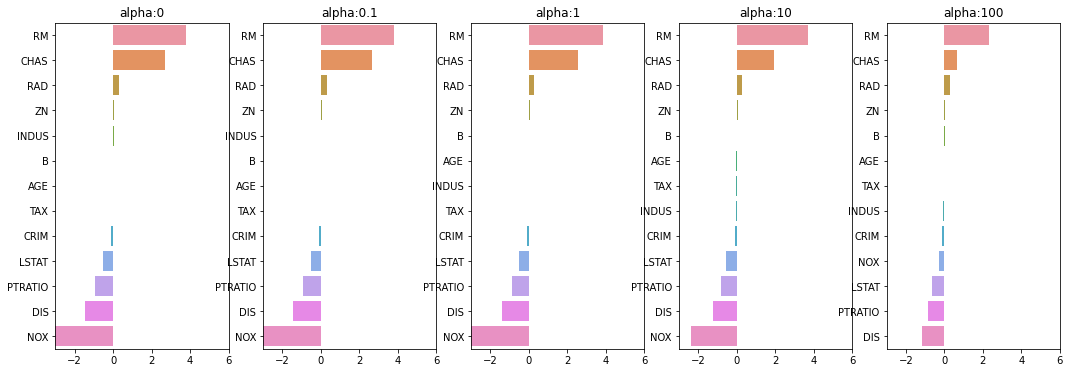

In [13]:
# 각 alpha에 따른 회귀 계수 값을 시각화하기 위해 5개의 열로 된 matplotlib 축 생성
fig, axs = plt.subplots(figsize = (18,6), nrows=1, ncols=5)

# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 dataframe 생성
coeff_df = pd.DataFrame()

# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장, pos: axis의 위치 지정
for pos, a in enumerate(alphas):
    ridge = Ridge(alpha=a)
    ridge.fit(X_data, y_target)
    
    # alpha에 따른 피처별로 회귀 계수를 Series로 변환하고 이를 DataFrame의 column으로 추가
    coeff = pd.Series(data=ridge.coef_, index=X_data.columns)
    colname = 'alpha:'+str(a)
    coeff_df[colname]=coeff
    
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수 값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3, 6)
    sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])

# for문 바깥에서 matplotlib의 show 호출 및 alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시
plt.show()

In [14]:
ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


* alpha값을 계속 증가시킬수록 회귀 계수 값은 작아짐
* 회귀 계수가 0으로 가진 않음

## 라쏘 회귀

* W의 절댓값(L1 Regularization)에 대해 페널티를 부여하는 방식
* L2 Regularization이 회귀 계수의 크기를 감소시키는데 반해, L1 Reg.에서는 불필요한 회귀 계수를 급격하게 감소시켜 0으로 만듦
    * 적절한 피처만 회귀에 포함시키는 피처 선택의 특징을 가지고 있음

In [23]:
from sklearn.linear_model import Lasso, ElasticNet

# alpha값에 따라 회귀 모델의 폴드 평균 RMSE를 출력하고 회귀 계수 값들을 DataFrame으로 반환
# verbose: a general programming term for produce lots of logging output
def get_linear_reg_eval(model_name, params = None, X_data_n = None, y_target_n = None, verbose = True, return_coeff= True):
        coeff_df = pd.DataFrame()
        if verbose:
            print("#######", model_name, "#######")
        
        for p in params:
            if model_name == "Ridge":
                model = Ridge(alpha = p)
            elif model_name == "Lasso":
                model = Lasso(alpha = p)
            elif model_name == "ElasticNet":
                model = ElasticNet(alpha = p, l1_ratio=0.7)
            
            # 오차 구하기
            neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring = "neg_mean_squared_error", cv = 5)
            avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
            print("alpha {0} 일 때 5 fold set의 평균 RMSE: {1:.3f} ".format(p, avg_rmse))
            
            # cross_val_score는 evaluation metirc만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
            model.fit(X_data_n, y_target_n)
            if return_coeff:
                # alpha에 따른 피처별 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가
                coeff = pd.Series(data=model.coef_, index=X_data_n.columns)
                colname = 'alpha:'+str(p)
                coeff_df[colname] = coeff
        
        return coeff_df

In [24]:
# 라쏘에 사용될 alpha 파라미터의 값을 정의하고 get_linear_reg_eval() 함수 호출
lasso_alphas = [0.07, 0.1, 0.5, 1.3]
coeff_lasso_df = get_linear_reg_eval("Lasso", params = lasso_alphas, X_data_n = X_data, y_target_n = y_target)

####### Lasso #######
alpha 0.07 일 때 5 fold set의 평균 RMSE: 5.612 
alpha 0.1 일 때 5 fold set의 평균 RMSE: 5.615 
alpha 0.5 일 때 5 fold set의 평균 RMSE: 5.669 
alpha 1.3 일 때 5 fold set의 평균 RMSE: 5.845 


alpha 0.07일 때 가장 좋은 rmse

In [25]:
# alpha값에 따른 피처별 회귀 계수
# 반환된 coeff_lasso_df를 첫 번째 column 순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column = "alpha:"+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending = False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1.3
RM,3.789725,3.703202,2.498212,0.018113
CHAS,1.434343,0.955190,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.255433
ZN,0.049059,0.049211,0.049544,0.048850
B,0.010248,0.010249,0.009469,0.007507
NOX,-0.000000,-0.000000,-0.000000,-0.000000
AGE,-0.011706,-0.010037,0.003604,0.031350
TAX,-0.014290,-0.014570,-0.015442,-0.014981
INDUS,-0.042120,-0.036619,-0.005253,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.051638


* alpha의 크기가 증가함에 따라 일부 피처의 회귀 계수는 0으로 바뀌고 있음 (CHAS- 0.5, 1.3 / NOX)
* 회귀 계수가 0인 피처는 회귀 식에서 제외되면서 피처 선택의 효과를 얻을 수 있음

## 엘라스틱넷 회귀

* L1 Regularization + L2 Regularization
* cost function = RSS(W) + alpha2 * $||W||^2_2$ + alpha1 * $||W||_1$

[엘라스텍넷 회귀]
* 라쏘: 서로 상관관계가 높은 피처들의 경우, 이들 중에서 중요피처만 셀렉션하고 다른 피처들은 모두 회귀 계수를 0으로 만드는 성향이 강함
* 이러한 성향으로 인해 alpha값에 따라 회귀 계수의 값이 급격히 변동할 수 있는데, 이를 완화하기 위해 라쏘에 L2 Regularization 추가
* 단점: 수행시간이 상대적으로 오래 걸림

* 주요 생성 파라미터: alpha, l1_ratio
* alpha = alpha1 + alpha2, l1_ratio = alpha1 / (alpha1 + alpha2)
    * l1_ratio가 0이면 a=0이므로 L2 Regularization과 동일
    * l2_ratio가 0이면 b=0이므로 L1 Regularization과 동일

In [27]:
# 엘라스틱넷에 사용될 alpha 파라미터의 값들을 정의하고 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정
elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval("ElasticNet", params = elastic_alphas, X_data_n = X_data, y_target_n = y_target)

####### ElasticNet #######
alpha 0.07 일 때 5 fold set의 평균 RMSE: 5.542 
alpha 0.1 일 때 5 fold set의 평균 RMSE: 5.526 
alpha 0.5 일 때 5 fold set의 평균 RMSE: 5.467 
alpha 1 일 때 5 fold set의 평균 RMSE: 5.597 
alpha 3 일 때 5 fold set의 평균 RMSE: 6.068 


alpha가 0.5일 때 가장 좋은 rmse

In [28]:
# 반환된 coeff_elastic_df를 첫 번째 칼럼순으로 내림차순 정렬해 회귀계수 DataFrame 출력
sort_column = "alpha:"+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


# 선형 회귀 모델을 위한 데이터 변환

* 선형 모델: feature와 target 간의 선형의 관계가 있다고 가정 → 최적의 선형함수를 찾아내 결과값을 예측
* 선형 회귀 모델: feature값, target값의 분포가 정규분포형태를 매우 선호
* target값, 정규 분포 형태가 아니라 특정값의 분포가 치우친 왜곡(Skew)된 형태의 분포도일 경우 예측 성능에 부정적인 영향을 미칠 가능성이 높음
* feature값, target값 보다는 덜하지만 역시 왜곡된 분포도로 인해 예측 성능에 부정적인 영향을 미칠 수 있음
* 따라서, 선형회귀모델을 적용하기 전에 분포도가 심하게 왜곡된 경우 데이터에 대한 스케일링/정규화 작업을 수행함 (무조건적인 성능 향상을 보장하지는 않음)

* 스케일링/정규화 작업  
    1) StandardScaler클래스를 이용해 평균이 0, 분산이 1인 표준 정규 분포를 가진 데이터 세트로 변환하거나 MinMaxScaler 클래스를 이용해 최솟값이 0이고 최댓값이 1인 값으로 정규화를 수행함  
    2) 스케일링/정규화를 수행한 데이터 세트에 다시 다항 특성을 적용하여 변환하는 방법임. 보통 1번 방법을 통해 예측 성능에 향상이 없을 경우 이와 같은 방법을 적용함.  
    3) 원래 값에 log함수를 적용하면 보다 정규 분포에 가까운 형태로 값이 분포됨. 이러한 변환을 log 변환이라고 부름. 로그 변환은 매우 유용한 변환이며, 실제로 선형 회귀에서는 앞에서 소개한 1,2 번 방법보다 로그 변환이 훨씬 많이 사용되는 변환 방법임. 왜냐하면 1번 방법의 경우, 예측 성능 향상을 크게 기대하기 어려운 경우가 많으며 2번 방법의 경우 피처의 개수가 매우 많을 경우에는 다항 변환으로 생성되는 피처의 개수가 기하급수로 늘어서 과적합의 이슈가 발생할 수 있기 때문

In [32]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# method는 표준 정규 분포 변환(Standard), 최댓값/최솟값 정규화(MinMax), 로그변환(Log) 결정
# p_degree는 다항식 특성을 추가할 때 적용, p_degree는 2이상 부여하지 않음
def get_scaled_data(method="None", p_degree=None, input_data = None):
    if method == "Standard":
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == "MinMax":
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == "Log":
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data
    
    if p_degree != None:
        scaled_data = PolynomialFeatures(degree = p_degree, include_bias = False).fit_transform(scaled_data)
    
    return scaled_data

In [33]:
# Ridge의 alpha 값을 다르게 적용하고 다양한 데이터 변환 방법에 따른 RMSE 추출
alphas = [0.1, 1, 10, 100]

# 5개 방식으로 변환, 먼저 원본 그대로, 표준정규 분포, 표준정규 분포+다항식 특성
# 최대/최소 정규화, 최대/최소 정규화+다항식 특성, 로그 변환
scale_methods = [(None, None), ("Standard", None), ("Standard", 2), ("MinMax", None), ("MinMax", 2), ("Log", None)]
for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(method = scale_method[0], p_degree=scale_method[1], input_data = X_data)
    print("\n ## 변환 유형: {0}, Polynomial Degree: {1}".format(scale_method[0], scale_method[1]))
    get_linear_reg_eval("Ridge", params=alphas, X_data_n = X_data_scaled, y_target_n = y_target, verbose=False, return_coeff = False)


 ## 변환 유형: None, Polynomial Degree: None
alpha 0.1 일 때 5 fold set의 평균 RMSE: 5.788 
alpha 1 일 때 5 fold set의 평균 RMSE: 5.653 
alpha 10 일 때 5 fold set의 평균 RMSE: 5.518 
alpha 100 일 때 5 fold set의 평균 RMSE: 5.330 

 ## 변환 유형: Standard, Polynomial Degree: None
alpha 0.1 일 때 5 fold set의 평균 RMSE: 5.826 
alpha 1 일 때 5 fold set의 평균 RMSE: 5.803 
alpha 10 일 때 5 fold set의 평균 RMSE: 5.637 
alpha 100 일 때 5 fold set의 평균 RMSE: 5.421 

 ## 변환 유형: Standard, Polynomial Degree: 2
alpha 0.1 일 때 5 fold set의 평균 RMSE: 8.827 
alpha 1 일 때 5 fold set의 평균 RMSE: 6.871 
alpha 10 일 때 5 fold set의 평균 RMSE: 5.485 
alpha 100 일 때 5 fold set의 평균 RMSE: 4.634 

 ## 변환 유형: MinMax, Polynomial Degree: None
alpha 0.1 일 때 5 fold set의 평균 RMSE: 5.764 
alpha 1 일 때 5 fold set의 평균 RMSE: 5.465 
alpha 10 일 때 5 fold set의 평균 RMSE: 5.754 
alpha 100 일 때 5 fold set의 평균 RMSE: 7.635 

 ## 변환 유형: MinMax, Polynomial Degree: 2
alpha 0.1 일 때 5 fold set의 평균 RMSE: 5.298 
alpha 1 일 때 5 fold set의 평균 RMSE: 4.323 
alpha 10 일 때 5 fold set의 평균 RMSE: 5.185 
a

log변환을 할 때, alpha 100을 제외하고 좋은 성능을 보임